In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import os
import re

#  KONFIGURATION PFAD 
#Ordner
pfad_zu_dateien = "/Users/zen/Desktop/DIS08_Data_modeling_7er_Gruppe-final_cleanUp/Data/raw/blaulicht_scraping" 

#Dateien im Ordner
dateien = [
    "Muenchen_blaulicht_scrape_2025-12-18.csv",
    "Chemnitz_blaulicht_scrape_2025-12-07.csv",
    "Dortmund_blaulicht_scrape_2025-12-07.csv",
    "Erfurt_blaulicht_scrape_2025-12-09.csv",
    "Nuernberg_blaulicht_scrape_2025-12-09.csv",
    "Saarbruecken_blaulicht_scrape_2025-12-09.csv",
]

all_docs = []
doc_metadata = []

print(f"Lade Daten aus Ordner: {pfad_zu_dateien}")

# SCHRITT 1: DATEN LADEN  
for file_name in dateien:
    # Pfad zusammenbauen Ordner + Dateiname
    voller_pfad = os.path.join(pfad_zu_dateien, file_name)
    
    # Prüfen, ob die Datei existiert
    if os.path.exists(voller_pfad):
        try:
            # Pandas liest jetzt vom lokalen Pfad
            df = pd.read_csv(voller_pfad, on_bad_lines='skip') 
            
            # Spalten bereinigen
            df.columns = [c.lower() for c in df.columns]
            
            #Text kombinieren (Title + Abstract)
            if 'title' in df.columns and 'abstract' in df.columns:
                df['text'] = df['title'].astype(str) + " " + df['abstract'].astype(str)
            else:
                df['text'] = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
            
            #Stadt aus Dateinamen extrahieren
            stadt_name = file_name.split('_')[0]
            
            #Jahr aus Datum extrahieren
            if 'datum' in df.columns:
                df['jahr'] = df['datum'].astype(str).str.extract(r'(\d{4})')
            else:
                df['jahr'] = 'Unbekannt'
            
            #Daten sammeln
            for text, jahr in zip(df['text'], df['jahr']):
                all_docs.append(text)
                doc_metadata.append({
                    'Stadt': stadt_name, 
                    'Jahr': jahr,
                    'Original_Datei': file_name
                })
                
            print(f"OK: {file_name} geladen.")

        except Exception as e:
            print(f"FEHLER bei {file_name}: {e}")
    else:
        print(f"NICHT GEFUNDEN: {voller_pfad}")

#  SCHRITT 2: ANALYSE (TF-IDF) 
if not all_docs:
    print("Keine Daten geladen.")
else:
    print(f"\n{len(all_docs)} Dokumente insgesamt. Starte TF-IDF Analyse...")

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(all_docs)
    feature_names = vectorizer.get_feature_names_out()

    # Keyword-Liste
    suchbegriffe = ['drogen', 'kokain', 'koks', 'droge', 'mdma', 'methamphetamin', 'methamphetamine']
    
    # Indizes der Keywords im Vokabular finden
    target_indices = [np.where(feature_names == k)[0][0] for k in suchbegriffe if k in feature_names]

    if target_indices:
        # Summe der Scores berechnen
        scores = np.asarray(tfidf_matrix[:, target_indices].sum(axis=1)).flatten()
        
        # Ergebnisse verknüpfen
        ergebnis_liste = []
        for i, meta in enumerate(doc_metadata):
            ergebnis_liste.append({
                'Stadt': meta['Stadt'],
                'Jahr': meta['Jahr'],
                'Score': scores[i]
            })
        
        ergebnis_df = pd.DataFrame(ergebnis_liste)
        
        #Ungültige Jahre entfernen
        ergebnis_df = ergebnis_df.dropna(subset=['Jahr'])

        #'coerce' sorgt dafür, dass Fehlerzu NaN werden
        ergebnis_df['Jahr_Num'] = pd.to_numeric(ergebnis_df['Jahr'], errors='coerce')
        
        #Nur Zeilen behalten, wo Jahr >= 2020 ist
        ergebnis_df = ergebnis_df[ergebnis_df['Jahr_Num'] >= 2020]
        
        #  SCHRITT 3: AGGREGATION & DIFFERENZEN 
        
        # Gruppieren nach Stadt und Jahr
        zusammenfassung = ergebnis_df.groupby(['Stadt', 'Jahr']).agg(
            Gesamt_Berichte=('Score', 'count'),
            Relevante_Berichte=('Score', lambda x: (x > 0).sum()), 
            Durchschnitts_Score=('Score', 'mean')                                               ####Raus score nicht nötig 
        ).reset_index()
        
        #Frequenz berechnen
        zusammenfassung['Frequenz_Prozent'] = (zusammenfassung['Relevante_Berichte'] / zusammenfassung['Gesamt_Berichte']) * 100
        
        #Sortieren (Stadt -> Jahr)
        zusammenfassung = zusammenfassung.sort_values(by=['Stadt', 'Jahr'])

        #Differenzen berechnen
        zusammenfassung['Diff_Score'] = zusammenfassung.groupby('Stadt')['Durchschnitts_Score'].diff()          ####Raus score nicht nötig 
        zusammenfassung['Diff_Frequenz'] = zusammenfassung.groupby('Stadt')['Frequenz_Prozent'].diff()

        #Runden
        zusammenfassung = zusammenfassung.round(4)
        
        # Ausgabe im Terminal
        print("\n--- Analyse-Ergebnis ---")
        print(zusammenfassung.to_string()) 
        
        # Speichern
        output_filename = 'drogen_analyse_lokale_daten.csv'
        
        zusammenfassung.to_csv(output_filename, index=False, sep=';', decimal=',')
        print(f"\nDatei erfolgreich gespeichert: {output_filename}")

    else:
        print("Keine der Suchbegriffe im Textkorpus gefunden.")

Lade Daten aus Ordner: /Users/zen/Desktop/DIS08_Data_modeling_7er_Gruppe-final_cleanUp/Data/raw/blaulicht_scraping
OK: Muenchen_blaulicht_scrape_2025-12-18.csv geladen.
OK: Chemnitz_blaulicht_scrape_2025-12-07.csv geladen.
OK: Dortmund_blaulicht_scrape_2025-12-07.csv geladen.
OK: Erfurt_blaulicht_scrape_2025-12-09.csv geladen.
OK: Nuernberg_blaulicht_scrape_2025-12-09.csv geladen.
OK: Saarbruecken_blaulicht_scrape_2025-12-09.csv geladen.

28248 Dokumente insgesamt. Starte TF-IDF Analyse...

--- Analyse-Ergebnis ---
           Stadt  Jahr  Gesamt_Berichte  Relevante_Berichte  Durchschnitts_Score  Frequenz_Prozent  Diff_Score  Diff_Frequenz
0       Chemnitz  2020               56                   2               0.0046            3.5714         NaN            NaN
1       Chemnitz  2021               62                   0               0.0000            0.0000     -0.0046        -3.5714
2       Chemnitz  2022               90                   0               0.0000            0.0000   

In [30]:
os.getcwd()

'/'

In [ ]:
import os

projekt_pfad = "/Users/zen/Desktop/DIS08_Data_modeling_7er_Gruppe-final_cleanUp"
os.chdir(projekt_pfad)

print(f"Neuer Arbeitsordner: {os.getcwd()}")

Neuer Arbeitsordner: /Users/zen/Desktop/DIS08_Data_modeling_7er_Gruppe-final_cleanUp


Lade Dateien aus: /Users/zen/Desktop/DIS08_Data_modeling_7er_Gruppe-final_cleanUp/Data/raw/blaulicht_scraping
✓ Muenchen_blaulicht_scrape_2025-12-18.csv analysiert.
✓ Chemnitz_blaulicht_scrape_2025-12-07.csv analysiert.
✓ Dortmund_blaulicht_scrape_2025-12-07.csv analysiert.
✓ Erfurt_blaulicht_scrape_2025-12-09.csv analysiert.
✓ Nuernberg_blaulicht_scrape_2025-12-09.csv analysiert.
✓ Saarbruecken_blaulicht_scrape_2025-12-09.csv analysiert.

Gefundene Häufigkeiten: {'drogen': 831, 'kokain': 279, 'koks': 2, 'droge': 37, 'mdma': 24, 'methamphetamin': 42, 'methamphetamine': 2}

Erstelle exklusive Wordcloud...


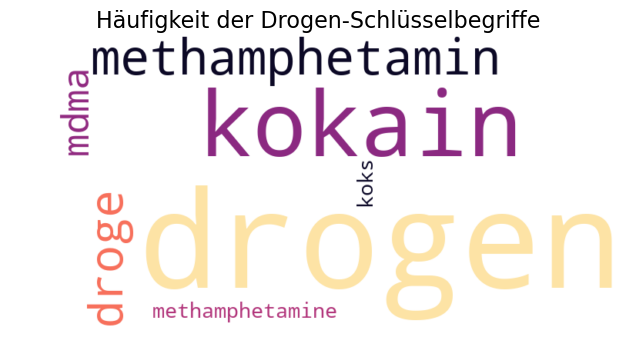

Wordcloud gespeichert als 'drogen_keywords_cloud.png'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import re

#Pfand / Dateien im Ordner
pfad_zu_dateien = "/Users/zen/Desktop/DIS08_Data_modeling_7er_Gruppe-final_cleanUp/Data/raw/blaulicht_scraping"

dateien = [
    "Muenchen_blaulicht_scrape_2025-12-18.csv",
    "Chemnitz_blaulicht_scrape_2025-12-07.csv",
    "Dortmund_blaulicht_scrape_2025-12-07.csv",
    "Erfurt_blaulicht_scrape_2025-12-09.csv",
    "Nuernberg_blaulicht_scrape_2025-12-09.csv",
    "Saarbruecken_blaulicht_scrape_2025-12-09.csv",
]

#Liste
target_keywords = ['drogen', 'kokain', 'koks', 'droge', 'mdma', 'methamphetamin', 'methamphetamine']

#speichern der Zählungen: {'drogen': 0, 'kokain': 0, ...}
keyword_counts = {k: 0 for k in target_keywords}

print(f"Lade Dateien aus: {pfad_zu_dateien}")

#zählen
for filename in dateien:
    voller_pfad = os.path.join(pfad_zu_dateien, filename)
    
    if os.path.exists(voller_pfad):
        try:
            df = pd.read_csv(voller_pfad, on_bad_lines='skip')
            
            # Text kombinieren
            df.columns = [c.lower() for c in df.columns]
            if 'title' in df.columns and 'abstract' in df.columns:
                df['text'] = df['title'].astype(str) + " " + df['abstract'].astype(str)
            else:
                df['text'] = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
            
            # Alles in Kleinbuchstaben umwandeln für den Vergleich
            full_text = " ".join(df['text'].tolist()).lower()
            
            #Zählen mit Regex (genaues Wort-Matching)
            for keyword in target_keywords:
                # \b sorgt dafür, dass "Drogen" nicht als Treffer für "Droge" zählt
                pattern = r'\b' + re.escape(keyword) + r'\b'
                matches = re.findall(pattern, full_text)
                keyword_counts[keyword] += len(matches)
                
            print(f"✓ {filename} analysiert.")
            
        except Exception as e:
            print(f"Fehler bei {filename}: {e}")
    else:
        print(f"Datei nicht gefunden: {filename}")

# 0-Werte entfernen sollte aber sauberer sein
keyword_counts = {k: v for k, v in keyword_counts.items() if v > 0}

print("\nGefundene Häufigkeiten:", keyword_counts)



#WORDCLOUD GENERIEREN
if keyword_counts:
    print("\nErstelle exklusive Wordcloud...")
    
    #Wichtig für die Darstellung (Größe, Farbe, ...)
    wordcloud = WordCloud(
        width=800,     
        height=400, 
        background_color='white', 
        colormap='magma', 
        prefer_horizontal=0.9
    ).generate_from_frequencies(keyword_counts)

    # Plotten
    plt.figure(figsize=(8, 4))
    
    #Bild to_image()
    plt.imshow(wordcloud.to_image(), interpolation='bilinear')
    
    
    plt.axis('off')
    plt.title("Häufigkeit der Drogen-Schlüsselbegriffe", fontsize=16)
    
    # Speichern
    plt.savefig('drogen_keywords_cloud.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Wordcloud gespeichert als 'drogen_keywords_cloud.png'")
else:
    print("Keine der Keywords wurden gefunden.")